In [2]:
from qpe import *
from numpy import log

import qutip as qp
from time import time

from numpy import sign, ceil
from numpy.random import randint

from scipy.stats import unitary_group, gaussian_kde
from scipy.integrate import quad

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rc('text', usetex=False)

In [3]:
def cfi(state_gen_func, state_gen_args, p, povm, n_copies=1, n_ext=0, dp=1e-5):
    dm = reduce(kron, [state_gen_func(p, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    dm_p = reduce(kron, [state_gen_func(p + dp, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    dm_m = reduce(kron, [state_gen_func(p - dp, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    fi = 0
    for op in povm:
        prob = trace(dot(dm, op)).real
        if prob > 0:
            prob_p = trace(dot(dm_p, op)).real
            prob_m = trace(dot(dm_m, op)).real
            der = (prob_p - prob_m)/(2*dp)
            fi += der**2/prob
    return fi

def qfi(state_gen_func, state_gen_args, p, n_copies=1, n_ext=0, dp=1e-2):
    dm = reduce(kron, [state_gen_func(p, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    dm_p = reduce(kron, [state_gen_func(p + dp, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    fi = 8*(1 - sqrt(fidelity(dm, dm_p))) / dp**2
    return fi

def qfi_central(state_gen_func, state_gen_args, p, n_copies=1, n_ext=0, dp=1e-2):
    dm_p = reduce(kron, [state_gen_func(p + dp, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    dm_m = reduce(kron, [state_gen_func(p - dp, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    fi = 8*(1 - sqrt(fidelity(dm_m, dm_p))) / dp**2/4
    return fi

In [4]:
def train_bayes(n_inp, n_layers, a, b, state_gen_func, prior_func, state_gen_args=[], prior_args=[], n_copies=1, n_meas=0, method="BFGS", x0=None, options={}):

    n_tot = n_inp*n_copies
    d = 2**n_tot
        
    if n_meas == 0:
        n_meas = n_tot
        
    n_pars_est = 2**n_meas
    n_pars_ans = (3*n_tot - 1)*n_layers + 2*n_tot # cry  
    
    # d_diff = 0 if n_tot == n_meas else 2**(n_tot - n_meas)
    d_diff = 2**(n_tot - n_meas)
    
    def fun_int(phi, x_est, U):
        dm = state_gen_func(phi, *state_gen_args)
        dm = reduce(kron, [dm]*n_copies)
        dm_u = U@dm@U.conj().T
        probs = dm_u.diagonal().real
        return np.sum((x_est - phi)**2*probs*prior_func(phi, *prior_args))

#     def fun_int(phi, x_est, U):
#         dm = state_gen_func(phi, *state_gen_args)
#         dm = reduce(kron, [dm]*n_copies)
#         dm_u = U@dm@U.conj().T
#         H = diag(x_est) - phi*eye(d)
#         H = H@H
#         return prior_func(phi, *prior_args)*trace(dm_u@H).real
    
    fvals = []
    fval_cont = [0]
    def fun(x):
        x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
        x_est = kron_A_I_diag(x_est, d_diff)
        # print(len(x_est))
        U = hea_cry_rzrx(n_tot, n_layers, x_ans)
        f = quad(fun_int, a, b, args=(x_est, U))[0]
        fval_cont[0] = f
        return f
        
    def callback(x):
        fvals.append(fval_cont[0])
        print("Iteration: %d | Function value: %.8f" %(len(fvals), fval_cont[0]), end="\r")
        return None
    
    if method in ["Nelder-Mead", "L-BFGS-B", "SLSQP", "TNC", "Powell", "COBYLA"]:
        bounds = [(0, pi)]*n_pars_ans + [(-10, 10)]*n_pars_est
    else:
        bounds = None
    if x0 is None:
        x0_ans = normal(pi, 0.01*pi, n_pars_ans)
        x0_est = normal(0, 0.01, n_pars_est)
        x0 = concatenate([x0_ans, x0_est])
    
    optimization_result = minimize(fun=fun, x0=x0, bounds=bounds, method=method, callback=callback, options=options) # "maxiter": int(1e10)

    return fvals, optimization_result

In [5]:
def train_bayes_naimark(n_inp, n_layers, a, b, state_gen_func, prior_func, state_gen_args=[], prior_args=[], n_copies=1, n_ext=1, method="BFGS", x0=None, options={}):

    n_tot = n_inp*n_copies + n_ext
    d = 2**n_tot
    d_prim =  2**(n_inp*n_copies)

    n_pars_est = 2**n_ext
    n_pars_ans = (3*n_tot - 1)*n_layers + 2*n_tot # cry  
            
    def fun_int(phi, x_est, U):
        dm = state_gen_func(phi, *state_gen_args)
        dm = reduce(kron, [dm]*n_copies + [P0]*n_ext)
        dm_u = U@dm@U.conj().T
        probs = dm_u.diagonal().real
        return np.sum((x_est - phi)**2*probs*prior_func(phi, *prior_args))

#     def fun_int(phi, x_est, U):
#         dm = state_gen_func(phi, *state_gen_args)
#         dm = reduce(kron, [dm]*n_copies)
#         dm_u = U@dm@U.conj().T
#         H = diag(x_est) - phi*eye(d)
#         H = H@H
#         return prior_func(phi, *prior_args)*trace(dm_u@H).real
    
    fvals = []
    fval_cont = [0]
    def fun(x):
        x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
        x_est = kron_I_A_diag(x_est, d_prim)
        U = hea_cry_rzrx(n_tot, n_layers, x_ans)
        f = quad(fun_int, a, b, args=(x_est, U))[0]
        fval_cont[0] = f
        return f
        
    def callback(x):
        fvals.append(fval_cont[0])
        print("Iteration: %d | Function value: %.8f" %(len(fvals), fval_cont[0]), end="\r")
        return None
    
    if method in ["Nelder-Mead", "L-BFGS-B", "SLSQP", "TNC", "Powell", "COBYLA"]:
        bounds = [(0, pi)]*n_pars_ans + [(-10, 10)]*n_pars_est
    else:
        bounds = None
    if x0 is None:
        x0_ans = normal(pi, 0.01*pi, n_pars_ans)
        x0_est = normal(0, 0.01, n_pars_est)
        x0 = concatenate([x0_ans, x0_est])
    
    optimization_result = minimize(fun=fun, x0=x0, bounds=bounds, method=method, callback=callback, options=options) # "maxiter": int(1e10)

    return fvals, optimization_result

In [12]:
def aux_info(n_inp, pars, a, b, state_gen_func, prior_func, n_layers, labels, state_gen_args=[], prior_args=[], n_copies=1, n_meas=0, dp=1e-5):

    n_tot = n_inp*n_copies
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    U = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [U.conj().T@proj@U for proj in projs]
    H = sum([x*proj for x, proj in zip(pars_est, projs_u)])
    H_sq = H@H

    def func_F(phi):
        CFI = cfi(state_gen_func, state_gen_args, phi, projs_u, n_copies=n_copies, n_ext=0, dp=dp)
        return CFI*prior_func(phi, *prior_args)
    def func_I(phi):
        prior_der = (prior_func(phi + dp, *prior_args) - prior_func(phi - dp, *prior_args))/(2*dp)
        return prior_der**2/prior_func(phi, *prior_args)
    def func_dphi(phi):
        return prior_func(phi, *prior_args)*phi**2
    def func_QBI(phi):
        dm = reduce(kron, [state_gen_func(phi, *state_gen_args)]*n_copies)
        return prior_func(phi, *prior_args)*trace(H_sq@dm).real
    
    int_F = quad(func_F, a, b)[0]
    int_I = quad(func_I, a, b)[0]
    CRB = 1/(int_F + int_I)
    QCRB = quad(func_F, a, b)[0] - quad(func_QBI, a, b)[0]

    dms = []
    dms_der = []
    for phi in labels:
        dm = reduce(kron, [state_gen_func(phi, *state_gen_args)]*n_copies)
        dm_p = reduce(kron, [state_gen_func(phi + dp, *state_gen_args)]*n_copies)
        dm_m = reduce(kron, [state_gen_func(phi - dp, *state_gen_args)]*n_copies)
        dm_der = (dm_p - dm_m)/(2*dp)
        dms.append(dm)
        dms_der.append(dm_der)

    expecs = []
    expecs_der = []
    disps = []
    for j in range(len(labels)): # take a density matrix from the training set
        probs = [trace(dms[j]@proj).real for proj in projs_u]
        probs_der = [trace(dms_der[j]@proj).real for proj in projs_u]
        expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
        expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
        disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
    
    return array(expecs), array(expecs_der), array(disps), CRB, QCRB#, int_F, int_I, H

In [28]:
def aux_info_naimark(n_inp, pars, a, b, state_gen_func, prior_func, n_layers, labels, state_gen_args=[], prior_args=[], n_copies=1, n_ext=1, dp=1e-5):

    n_tot = n_inp*n_copies + n_ext
    
    pars_ans = pars[:-2**n_ext]
    pars_est = pars[-2**n_ext:]
    
    U = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    projs = [kron(eye(2**n_inp), diag(line)) for line in eye(2**n_ext)]
    projs_u = [U.conj().T@proj@U for proj in projs]
    
    H = sum([x*proj for x, proj in zip(pars_est, projs_u)])
    H_sq = H@H

    def func_F(phi):
        CFI = cfi(state_gen_func, state_gen_args, phi, projs_u, n_copies=n_copies, n_ext=1, dp=dp)
        return CFI*prior_func(phi, *prior_args)
    def func_I(phi):
        prior_der = (prior_func(phi + dp, *prior_args) - prior_func(phi - dp, *prior_args))/(2*dp)
        return prior_der**2/prior_func(phi, *prior_args)
    def func_dphi(phi):
        return prior_func(phi, *prior_args)*phi**2
    def func_QBI(phi):
        dm = reduce(kron, [state_gen_func(phi, *state_gen_args)]*n_copies + [P0]*n_ext)
        return prior_func(phi, *prior_args)*trace(H_sq@dm).real
    
    int_F = quad(func_F, a, b)[0]
    int_I = quad(func_I, a, b)[0]
    CRB = 1/(int_F - int_I)
    QCRB = quad(func_F, a, b)[0] - quad(func_QBI, a, b)[0]

    dms = []
    dms_der = []
    for phi in labels:
        dm = reduce(kron, [state_gen_func(phi, *state_gen_args)]*n_copies + [P0]*n_ext)
        dm_p = reduce(kron, [state_gen_func(phi + dp, *state_gen_args)]*n_copies + [P0]*n_ext)
        dm_m = reduce(kron, [state_gen_func(phi - dp, *state_gen_args)]*n_copies + [P0]*n_ext)
        dm_der = (dm_p - dm_m)/(2*dp)
        dms.append(dm)
        dms_der.append(dm_der)

    expecs = []
    expecs_der = []
    disps = []
    for j in range(len(labels)): # take a density matrix from the training set
        probs = [trace(dms[j]@proj).real for proj in projs_u]
        probs_der = [trace(dms_der[j]@proj).real for proj in projs_u]
        expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
        expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
        disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
    
    return array(expecs), array(expecs_der), array(disps), CRB, QCRB#, int_F, int_I, H

In [29]:
expecs_ext, expecs_der_ext, disps_ext, CRB_ext, QCRB_ext = aux_info_naimark(n_inp, pars_ext, a, b, state_gen_func=state_gen_func, 
                                                                            state_gen_args=state_gen_args, prior_func=prior_func, 
                                                                            n_layers=n_layers_ext, labels=labels, n_copies=n_copies, 
                                                                            n_ext=n_ext, dp=dp)

# Ising

In [70]:
from scipy import sparse
from scipy.sparse.linalg import eigsh, spsolve

sX = sparse.csr_matrix([[0, 1],
                        [1, 0]])
sY = sparse.csr_matrix([[0, -1j],
                        [1j,  0]])
sZ = sparse.csr_matrix([[1,  0],
                        [0, -1]])
sI = sparse.csr_matrix([[1, 0],
                        [0, 1]])

def ising_ham_sparse(N, h, J=1, bt=False):
    d = 2**N
    
    Hz = sparse.csr_matrix((d, d))
    for q in range(N):
        Hz = Hz + reduce(sparse.kron, [sI]*q + [sZ] + [sI]*(N - q - 1))
        
    Hxx = sparse.csr_matrix((d, d))
    for q in range(N - 1):
        Hxx = Hxx + reduce(sparse.kron, [sI]*q + [sX, sX] + [sI]*(N - q - 2))
    Hxx = Hxx + reduce(sparse.kron, [sX] + [sI]*(N - 2) + [sX])
    
    if bt == True:
        Hxx = Hxx + reduce(sparse.kron, [sY] + [sZ]*(N - 2) + [sY])

    return J*(Hxx + h*Hz)

def ising_gs_gen(h, n_inp):
    ham = ising_ham_sparse(n_inp, h, J=1, bt=False)
    eigvals, eigvecs = eigsh(ham, 2)
    ind = np.argmin(eigvals)
    e0, v0 = eigvals[ind], eigvecs[:,ind]
    return v0

In [72]:
def train_bayes_pure(n_inp, n_layers, a, b, state_gen_func, prior_func, state_gen_args=[], prior_args=[], n_copies=1, n_meas=0, method="BFGS", x0=None, options={}):

    n_tot = n_inp*n_copies
    d = 2**n_tot
        
    if n_meas == 0:
        n_meas = n_tot
    n_pars_est = 2**n_meas
    n_pars_ans = (3*n_tot - 1)*n_layers + 2*n_tot # cry  
    
    # d_diff = 0 if n_tot == n_meas else 2**(n_tot - n_meas)
    d_diff = 2**(n_tot - n_meas)
    
    def fun_int(phi, x_est, U):
        sv = state_gen_func(phi, *state_gen_args)
        sv = reduce(kron, [sv]*n_copies)
        sv_u = U@sv
        probs = np.abs(sv_u)**2
        return np.sum((x_est - phi)**2*probs*prior_func(phi, *prior_args))

#     def fun_int(phi, x_est, U):
#         dm = state_gen_func(phi, *state_gen_args)
#         dm = reduce(kron, [dm]*n_copies)
#         dm_u = U@dm@U.conj().T
#         H = diag(x_est) - phi*eye(d)
#         H = H@H
#         return prior_func(phi, *prior_args)*trace(dm_u@H).real
    
    fvals = []
    fval_cont = [0]
    def fun(x):
        x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
        x_est = kron_A_I_diag(x_est, d_diff)
        # print(len(x_est))
        U = hea_cry_rzrx(n_tot, n_layers, x_ans)
        f = quad(fun_int, a, b, args=(x_est, U))[0]
        fval_cont[0] = f
        return f
        
    def callback(x):
        fvals.append(fval_cont[0])
        print("Iteration: %d | Function value: %.8f" %(len(fvals), fval_cont[0]), end="\r")
        return None
    
    if method in ["Nelder-Mead", "L-BFGS-B", "SLSQP", "TNC", "Powell", "COBYLA"]:
        bounds = [(0, pi)]*n_pars_ans + [(-10, 10)]*n_pars_est
    else:
        bounds = None
    if x0 is None:
        x0_ans = normal(pi, 0.01*pi, n_pars_ans)
        x0_est = normal(0, 0.01, n_pars_est)
        x0 = concatenate([x0_ans, x0_est])
    
    optimization_result = minimize(fun=fun, x0=x0, bounds=bounds, method=method, callback=callback, options=options) # "maxiter": int(1e10)

    return fvals, optimization_result

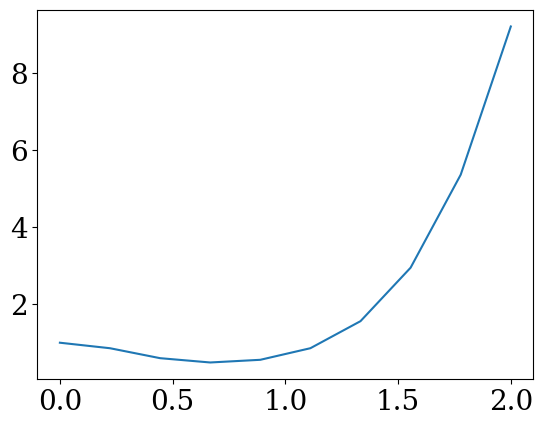

In [106]:
n_inp = 4
a, b = 1e-5, 2 - 1e-5
V = 10

labels = linspace(a, b, V)
svs = [ising_gs_gen(h, n_inp) for h in labels]

dh = 1e-3
QFIs = []
for h in labels:
    sv_p = ising_gs_gen(h + dh, n_inp)
    sv_m = ising_gs_gen(h - dh, n_inp)
    dm_p = outer(sv_p, sv_p.conj().T)
    dm_m = outer(sv_m, sv_m.conj().T)
    QFI = 2*(1 - sqrt(fidelity(dm_m, dm_p))) / dh**2 + 1e-10 # via centered differences
    QFIs.append(QFI)

plt.plot(labels, 1/array(QFIs))

In [137]:
method = "BFGS"
n_copies = 1
n_meas = 2#n_inp*n_copies
n_layers = 5

# x0 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), normal(0., 1, 2**n_meas)])
x0 = concatenate([normal(pi/2, 0.1, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), normal(0., 0.1, 2**n_meas)])

In [138]:
fvals_inf, result_inf = train_pure(svs, labels, n_layers, n_copies=n_copies, n_meas=n_meas, method="BFGS", 
                              w_ls=1, w_var=1, x0=x0, options={"maxiter": 1000}, fvals=[])
pars_inf = result_inf.x

In [139]:
state_gen_func = ising_gs_gen
state_gen_args = [n_inp]

prior_func = lambda p: 1/(b - a);
prior_args = []

fvals, result = train_bayes_pure(n_inp, n_layers, a, b, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func,
                                 prior_args=prior_args, n_copies=n_copies, n_meas=n_meas, method=method, x0=pars_inf, options={"maxiter": 1000})
pars = result.x

print("\n", result.message)

/tmp/ipykernel_72788/898440136.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  f = quad(fun_int, a, b, args=(x_est, U))[0]
/tmp/ipykernel_72788/898440136.py:36: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  f = quad(fun_int, a, b, args=(x_est, U))[0]

KeyboardInterrupt



# Isotropic

In [8]:
def dm_iso_p_gen(p):
    n_inp = 2 # generalize later some day
    d = 2**n_inp
    sv_bell = sum([kron(vec, vec) for vec in eye(int(d/2))])/sqrt(d/2)
    dm_bell = outer(sv_bell, sv_bell)
    return p*dm_bell + (1 - p)/4*eye(4)

def dm_iso_N_gen(N):
    n_inp = 2 # generalize later some day
    d = 2**n_inp
    sv_bell = sum([kron(vec, vec) for vec in eye(int(d/2))])/sqrt(d/2)
    dm_bell = outer(sv_bell, sv_bell)
    return (2*N + 1)/3*dm_bell + (1 - N)/6*eye(4)

In [9]:
n_inp = 2
p_min, p_max = 1/3, 1
a, b = 0, 1
V = 15

marks = "neg"

ps = linspace(p_min + 1e-5, p_max - 1e-5, V)
dms = [dm_iso_p_gen(p) for p in ps]
labels = [two_subsys_negativity(dm) for dm in dms]

dN = 1e-5
dms_check = []
QFIs = []
for N in labels:
    dm =   dm_iso_N_gen(N)
    dm_p = dm_iso_N_gen(N + dN)
    dm_m = dm_iso_N_gen(N - dN)
    QFI = 2*(1 - sqrt(fidelity(dm_m, dm_p))) / dN**2 + 1e-10 # via centered differences
    QFIs.append(QFI)
    dms_check.append(dm)

print(norm(array(dms) - array(dms_check)))

2.2034513096948663e-15


## 1 copy

In [40]:
method = "BFGS"
n_copies = 1

state_gen_func = dm_iso_N_gen
state_gen_args = []

dp = 1e-5

prior_func = lambda p: 1/(b - a); prior_args = []
# dphi = 1/sqrt(2)
# prior_func = lambda phi: exp(-(phi**2)/(2*dphi)**2)/sqrt(2*pi*dphi**2); prior_args = []

### $m=1$

In [41]:
n_meas_1 = 1 #n_inp*n_copies
n_layers_1 = 2
x0_1 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers_1 + 2*n_inp*n_copies), normal(0., 1, 2**n_meas_1)])

fvals_1, result_1 = train_bayes(n_inp, n_layers_1, a, b, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func,
                                prior_args=prior_args, n_copies=n_copies, n_meas=n_meas_1, method=method, x0=x0_1, options={})
pars_1 = result_1.x

print("\n", result_1.message)

expecs_1, expecs_der_1, disps_1, CRB_1, QCRB_1 = aux_info(n_inp, pars_1, a, b, state_gen_func=state_gen_func, 
                                                          state_gen_args=state_gen_args, prior_func=prior_func, n_layers=n_layers_1, 
                                                          labels=labels, n_copies=n_copies, n_meas=n_meas_1, dp=dp)

Iteration: 25 | Function value: 0.07777778
 Optimization terminated successfully.


In [42]:
expecs_1, expecs_der_1, disps_1

(array([0.46666926, 0.47143095, 0.47619265, 0.48095434, 0.48571603,
        0.49047772, 0.49523941, 0.5000011 , 0.50476279, 0.50952448,
        0.51428617, 0.51904786, 0.52380956, 0.52857125, 0.53333294]),
 array([0.06666568, 0.06666568, 0.06666568, 0.06666568, 0.06666568,
        0.06666568, 0.06666568, 0.06666568, 0.06666568, 0.06666568,
        0.06666568, 0.06666568, 0.06666568, 0.06666568, 0.06666568]),
 array([8.88855779e-03, 8.54843322e-03, 8.16296124e-03, 7.73214186e-03,
        7.25597507e-03, 6.73446088e-03, 6.16759929e-03, 5.55539029e-03,
        4.89783389e-03, 4.19493008e-03, 3.44667887e-03, 2.65308026e-03,
        1.81413425e-03, 9.29840825e-04, 2.00000757e-07]))

n_inp: 2 | n_copies: 1 | n_meas: 1 | n_layers: 2 


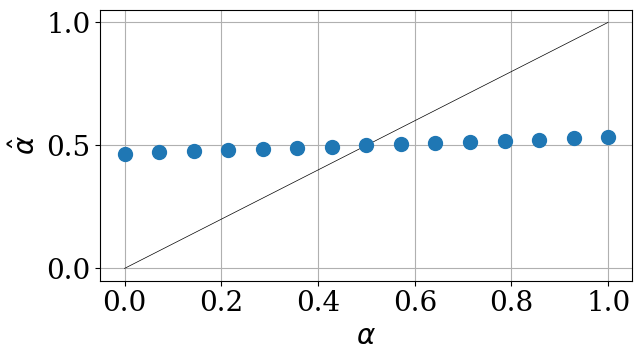

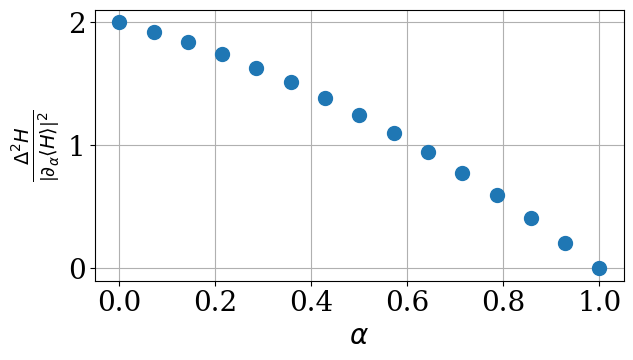

In [16]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas_1, n_layers_1))

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4))
# plt.plot(labels, expecs, zorder=10)
plt.scatter(labels, expecs_1, s=100, zorder=10)
plt.plot(labels, labels, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{\alpha}$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
# plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

biass_1 = expecs_1 - labels

plt.figure(figsize=(7, 4))
plt.scatter(labels, disps_1/expecs_der_1**2, s=100, zorder=10)
# plt.scatter(labels, disps + biass**2, s=100, zorder=10)
# plt.scatter(labels, disps, s=100, zorder=10)
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
# plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
# plt.yscale("log")
plt.show()

### $m=2$

In [17]:
n_meas_2 = 2 #n_inp*n_copies
n_layers_2 = 2
# x0_2 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers_2 + 2*n_inp*n_copies), normal(0., 1, 2**n_meas_2)])
x0_2 = concatenate([normal(pi/4, 0.1, (3*n_inp*n_copies - 1)*n_layers_2 + 2*n_inp*n_copies), normal(0., .1, 2**n_meas_2)])

fvals_2, result_2 = train_bayes(n_inp, n_layers_2, a, b, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func,
                                prior_args=prior_args, n_copies=n_copies, n_meas=n_meas_2, method=method, x0=x0_2, options={})
pars_2 = result_2.x

print("\n", result_2.message)

expecs_2, expecs_der_2, disps_2, CRB_2, QCRB_2 = aux_info(n_inp, pars_2, a, b, state_gen_func=state_gen_func, 
                                                          state_gen_args=state_gen_args, prior_func=prior_func, n_layers=n_layers_2, 
                                                          labels=labels, n_copies=n_copies, n_meas=n_meas_2, dp=dp)

Iteration: 30 | Function value: 0.07407407
 Optimization terminated successfully.


n_inp: 2 | n_copies: 1 | n_meas: 2 | n_layers: 2 


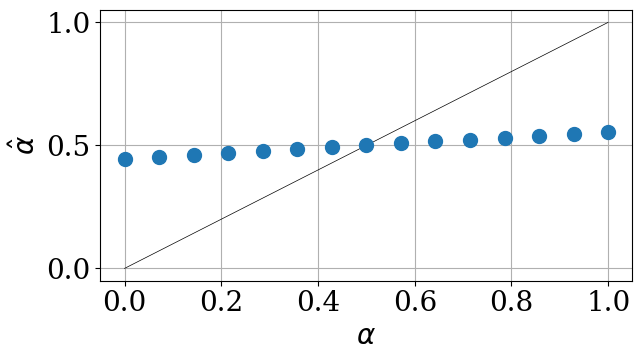

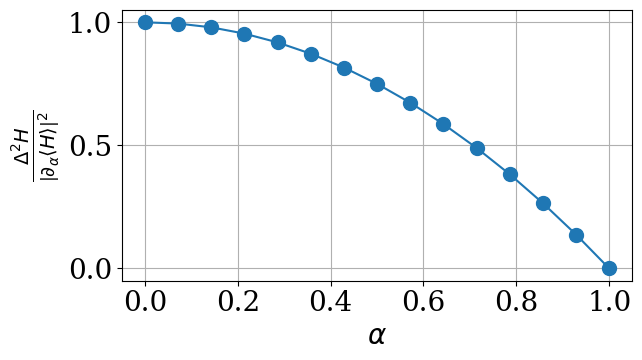

In [18]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas_2, n_layers_2))

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4))
# plt.plot(labels, expecs, zorder=10)
plt.scatter(labels, expecs_2, s=100, zorder=10)
plt.plot(labels, labels, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{\alpha}$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
# plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

biass_2 = expecs_2 - labels

plt.figure(figsize=(7, 4))
plt.scatter(labels, disps_2/expecs_der_2**2, s=100, zorder=10)
plt.plot(labels, [1-l**2 for l in labels])
# plt.scatter(labels, disps + biass**2, s=100, zorder=10)
# plt.scatter(labels, disps, s=100, zorder=10)
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
# plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
# plt.yscale("log")
plt.show()

In [44]:
expecs_2, expecs_der_2, disps_2

(array([0.44444179, 0.45237837, 0.46031495, 0.46825153, 0.47618811,
        0.48412469, 0.49206127, 0.49999785, 0.50793443, 0.51587101,
        0.52380759, 0.53174417, 0.53968075, 0.54761732, 0.5555539 ]),
 array([0.11111545, 0.11111545, 0.11111545, 0.11111545, 0.11111545,
        0.11111545, 0.11111545, 0.11111545, 0.11111545, 0.11111545,
        0.11111545, 0.11111545, 0.11111545, 0.11111545, 0.11111545]),
 array([1.23466439e-02, 1.22836282e-02, 1.20946338e-02, 1.17796608e-02,
        1.13387092e-02, 1.07717791e-02, 1.00788703e-02, 9.25998291e-03,
        8.31511693e-03, 7.24427236e-03, 6.04744919e-03, 4.72464742e-03,
        3.27586706e-03, 1.70110809e-03, 3.70521727e-07]))

### extension

In [34]:
n_ext = 1 #n_inp*n_copies
n_tot = n_inp*n_copies + n_ext
n_layers_ext = 3
# x0_ext = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers_ext + 2*n_inp*n_copies), normal(0., 1, 2**n_meas_ext)])
x0_ext = concatenate([normal(pi/4, 0.1, (3*n_tot - 1)*n_layers_ext + 2*n_tot), normal(0., .1, 2**n_ext)])

fvals_ext, result_ext = train_bayes_naimark(n_inp, n_layers_ext, a, b, state_gen_func=state_gen_func, state_gen_args=state_gen_args, 
                                            prior_func=prior_func, prior_args=prior_args, n_copies=n_copies, n_ext=n_ext, 
                                            method=method, x0=x0_ext, options={})
pars_ext = result_ext.x

print("\n", result_ext.message)



Iteration: 146 | Function value: 0.07407408
 Optimization terminated successfully.


In [37]:
expecs_ext, expecs_der_ext, disps_ext, CRB_ext, QCRB_ext = aux_info_naimark(n_inp, pars_ext, a, b, state_gen_func=state_gen_func, 
                                                                            state_gen_args=state_gen_args, prior_func=prior_func, 
                                                                            n_layers=n_layers_ext, labels=labels, n_copies=n_copies, 
                                                                            n_ext=n_ext, dp=dp)

n_inp: 2 | n_copies: 1 | n_ext: 1 | n_layers: 3 


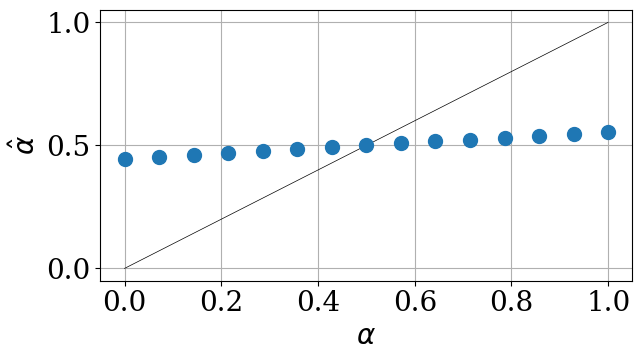

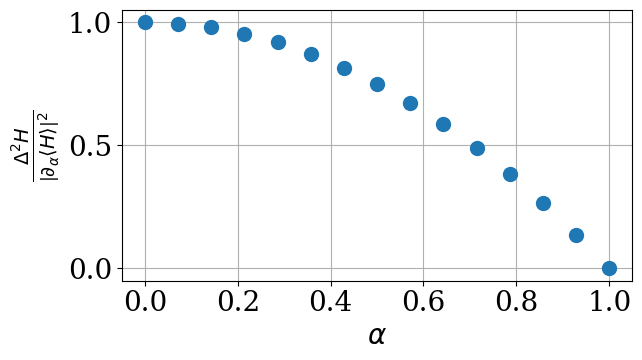

In [38]:
print("n_inp: %d | n_copies: %d | n_ext: %d | n_layers: %d " %(n_inp, n_copies, n_ext, n_layers_ext))

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4))
# plt.plot(labels, expecs, zorder=10)
plt.scatter(labels, expecs_ext, s=100, zorder=10)
plt.plot(labels, labels, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{\alpha}$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
# plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

biass_ext = expecs_ext - labels

plt.figure(figsize=(7, 4))
plt.scatter(labels, disps_ext/expecs_der_ext**2, s=100, zorder=10)
# plt.scatter(labels, disps + biass**2, s=100, zorder=10)
# plt.scatter(labels, disps, s=100, zorder=10)
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
# plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
# plt.yscale("log")
plt.show()

In [39]:
expecs_ext, expecs_der_ext, disps_ext

(array([0.44444557, 0.45238183, 0.4603181 , 0.46825436, 0.47619063,
        0.48412689, 0.49206316, 0.49999942, 0.50793568, 0.51587195,
        0.52380821, 0.53174448, 0.53968074, 0.547617  , 0.55555327]),
 array([0.11111103, 0.11111103, 0.11111103, 0.11111103, 0.11111103,
        0.11111103, 0.11111103, 0.11111103, 0.11111103, 0.11111103,
        0.11111103, 0.11111103, 0.11111103, 0.11111103, 0.11111103]),
 array([1.23456629e-02, 1.22826520e-02, 1.20936726e-02, 1.17787246e-02,
        1.13378080e-02, 1.07709229e-02, 1.00780691e-02, 9.25924682e-03,
        8.31445593e-03, 7.24369647e-03, 6.04696843e-03, 4.72427182e-03,
        3.27560663e-03, 1.70097287e-03, 3.70531543e-07]))

## 2 copies

In [18]:
method = "BFGS"
n_copies = 2
n_meas = n_inp*n_copies
n_layers = 3

state_gen_func = dm_iso_N_gen
state_gen_args = []

dp = 1e-5

prior_func = lambda p: 1/(b - a); prior_args = []
# dphi = 1/sqrt(2)
# prior_func = lambda phi: exp(-(phi**2)/(2*dphi)**2)/sqrt(2*pi*dphi**2); prior_args = []

x0 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), normal(0., 1, 2**n_meas)])

fvals, result = train_bayes(n_inp, n_layers, a, b, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func, prior_args=prior_args, n_copies=n_copies, n_meas=n_meas, method=method, x0=x0, options={})
pars = result.x

print("\n", result.message)

Iteration: 177 | Function value: 0.06622026
 Optimization terminated successfully.


n_inp: 2 | n_copies: 2 | n_meas: 4 | n_layers: 3 


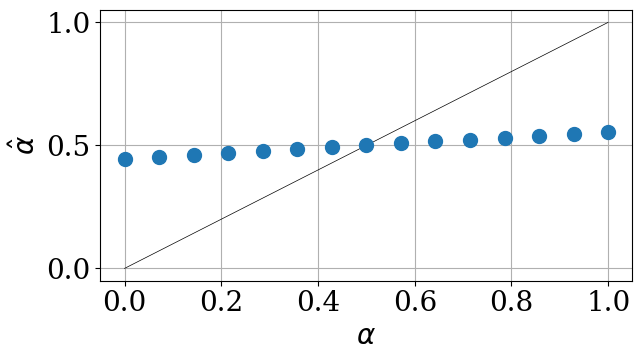

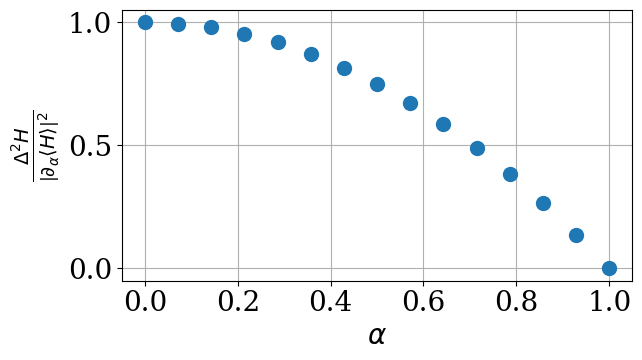

In [19]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas, n_layers))

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4))
# plt.plot(labels, expecs, zorder=10)
plt.scatter(labels, expecs, s=100, zorder=10)
plt.plot(labels, labels, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{\alpha}$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
# plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

biass = expecs - labels

plt.figure(figsize=(7, 4))
plt.scatter(labels, disps/expecs_der**2, s=100, zorder=10)
# plt.scatter(labels, disps + biass**2, s=100, zorder=10)
# plt.scatter(labels, disps, s=100, zorder=10)
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
# plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
# plt.yscale("log")
plt.show()

# Bell

In [5]:
def bell_state_gen(neg, n_inp, return_dm=False):
    d = 2**n_inp    
    s0n = array([1] + [0]*(d - 1))
    s1n = array([0]*(d - 1) + [1])
    g = sqrt(max(0, 1 - neg**2)) # cope negative sqrt
    v = (sqrt(1 + g)*s0n + sqrt(1 - g)*s1n)/sqrt(2)
    if return_dm == False:
        return v
    else:
        return outer(v, v.conj().T)
    
def bell_state_der_gen(neg, n_inp, return_dm=False):
    d = 2**n_inp
    s0n = array([1] + [0]*(2**n_inp - 1))
    s1n = array([0]*(2**n_inp - 1) + [1])
    g_p = sqrt(1 + neg)
    g_m = sqrt(1 - neg)
    n1 = -N/(2*g_m*g_p*sqrt(1 + g_m*g_p))
    n2 =  N/(2*g_m*g_p*sqrt(1 - g_m*g_p))
    v_der = (n1*s0n + n2*s1n)/sqrt(2)
    if return_dm == False:
        return v_der
    else:
        return outer(v_der, v_der.conj().T)

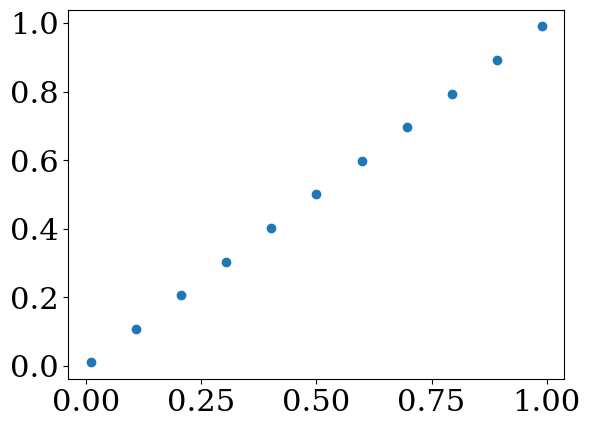

In [6]:
state_gen_func = bell_state_gen
n_inp = 2
return_dm = True
state_gen_args = [n_inp, return_dm]

a = 0 + 1e-2
b = 1 - 1e-2
T = 11

labels = linspace(a, b, T)#[1:-1]
dms = [state_gen_func(p, *state_gen_args) for p in labels]

plt.scatter(labels, labels)

In [7]:
method = "BFGS"
n_copies = 1
n_meas = n_inp*n_copies
n_layers = 1

dp = 1e-5

prior_func = lambda p: 1/(b - a); prior_args = []
# dphi = 1/sqrt(2)
# prior_func = lambda phi: exp(-(phi**2)/(2*dphi)**2)/sqrt(2*pi*dphi**2); prior_args = []

x0 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), normal(0., 1, 2**n_meas)])

fvals, result = train_bayes(n_layers, a, b, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func, prior_args=prior_args, n_copies=n_copies, n_meas=n_meas, method=method, x0=x0, options={})
pars = result.x

print("\n", result.message)

Iteration: 109 | Function value: 0.07034872
 Optimization terminated successfully.


In [8]:
expecs, expecs_der, disps, CRB, QCRB = aux_info(n_inp, pars, a, b, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func, n_layers=n_layers, labels=labels, n_copies=n_copies, n_meas=n_meas, dp=dp)

n_inp: 2 | n_copies: 1 | n_meas: 2 | n_layers: 1 


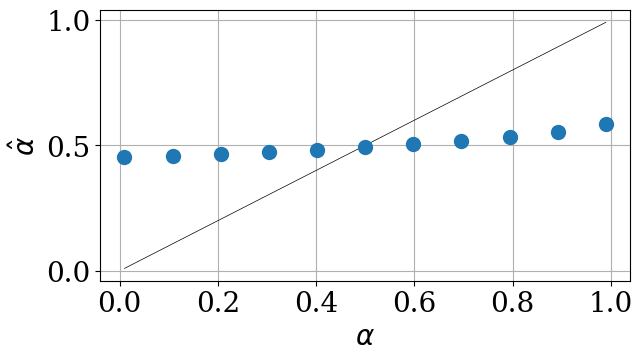

In [9]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas, n_layers))

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4))
# plt.plot(labels, expecs, zorder=10)
plt.scatter(labels, expecs, s=100, zorder=10)
plt.plot(labels, labels, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{\alpha}$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
# plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

biass = expecs - labels

plt.figure(figsize=(7, 4))
plt.scatter(labels, disps/expecs_der**2, s=100, zorder=10)
# plt.scatter(labels, disps + biass**2, s=100, zorder=10)
# plt.scatter(labels, disps, s=100, zorder=10)
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
# plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
# plt.yscale("log")
plt.show()

In [10]:
result.fun, CRB, QCRB

(0.07034872426469974, 0.3716836612179184, 2.4307773311190846)

In [11]:
expecs

array([0.45171637, 0.45838562, 0.46586494, 0.4741941 , 0.48344513,
       0.4937362 , 0.50526015, 0.51834847, 0.53364134, 0.55271663,
       0.58461148])

In [12]:
expecs_der

array([0.06398886, 0.07214212, 0.08056361, 0.08953955, 0.0994535 ,
       0.11088659, 0.12483601, 0.14328581, 0.17112562, 0.22627701,
       0.64327129])

In [13]:
disps

array([0.00409417, 0.00514378, 0.00621507, 0.0072764 , 0.00829258,
       0.00922188, 0.01001112, 0.01058537, 0.01082231, 0.01046227,
       0.00823458])

In [198]:
method = "BFGS"
n_copies = 1
n_inp = int(log2(len(dm_ini)))
n_meas = n_inp*n_copies
n_layers = 1

dp = 1e-2
x0 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), normal(0., 1, 2**n_meas)])
prior_func = lambda phi, dphi: exp(-(phi**2)/(2*dphi)**2)/sqrt(2*pi*dphi**2); prior_args = [dphi]

In [231]:
a = -pi - 1e-2
b = pi + 1e-2
dphi_list = linspace(0.075, 1, 20)
mse_list = []
CRB_list = []
int_F_list = []
int_I_list = []
for dphi in dphi_list:
    print(dphi)
    print()
    prior_args = [dphi]
    fvals, result = train_bayes(n_layers, a, b, prior_func, prior_args, n_copies=n_copies, n_meas=n_meas, method=method, x0=x0, options={})
    pars = result.x
    expecs, expecs_der, disps, CRB, int_F, int_I, H = aux_info_exact(pars, a, b, channel_func, channel_args, prior_func, prior_args, dm_ini, n_layers, labels, n_copies=n_copies, n_meas=n_meas, dp=dp)
    mse_list.append(result.fun)
    CRB_list.append(CRB)
    int_F_list.append(int_F)
    int_I_list.append(int_I)
    print()

0.075

Iteration: 17 | Function value: 0.01573292
0.12368421052631579

Iteration: 14 | Function value: 0.04198473
0.1723684210526316

Iteration: 22 | Function value: 0.07932961
0.2210526315789474

Iteration: 20 | Function value: 0.12595962
0.26973684210526316

Iteration: 17 | Function value: 0.17990017
0.318421052631579

Iteration: 15 | Function value: 0.23929941
0.36710526315789477

Iteration: 13 | Function value: 0.30271067
0.4157894736842106

Iteration: 12 | Function value: 0.36933141
0.46447368421052637

Iteration: 11 | Function value: 0.43915280
0.5131578947368421

Iteration: 11 | Function value: 0.51292197
0.5618421052631579

Iteration: 11 | Function value: 0.59179708
0.6105263157894737

Iteration: 11 | Function value: 0.67675476
0.6592105263157895

Iteration: 10 | Function value: 0.76804180
0.7078947368421052

Iteration: 9 | Function value: 0.86493602
0.7565789473684211

Iteration: 10 | Function value: 0.96585483
0.8052631578947369

Iteration: 10 | Function value: 1.06867546
0.8

/tmp/ipykernel_534478/786132823.py:1: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(dphi_list, sqrt(array(mse_list)/(1 - array(int_I_list)*array(mse_list))))


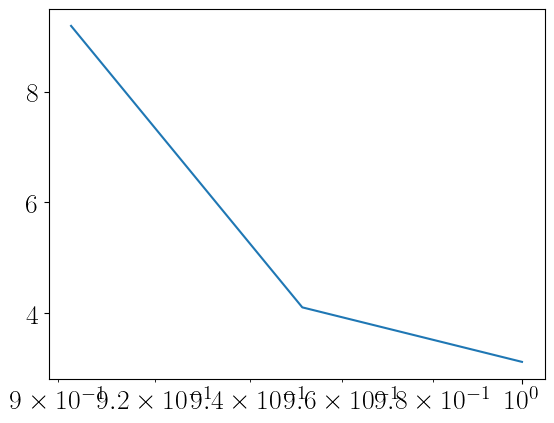

In [232]:
plt.plot(dphi_list, sqrt(array(mse_list)/(1 - array(int_I_list)*array(mse_list))))
# plt.plot(dphi_list, CRB_list)
# plt.plot(dphi_list, array([exp((n_copies*dphi)**2)/n_copies**2 - dphi**2 for dphi in dphi_list]))
plt.xscale("log")

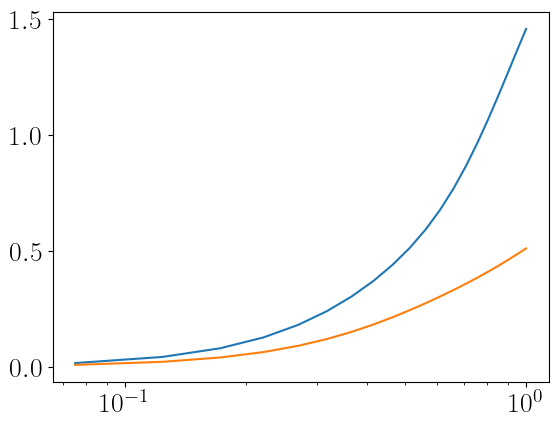

In [233]:
plt.plot(dphi_list, array(mse_list))
plt.plot(dphi_list, CRB_list)
plt.xscale("log")

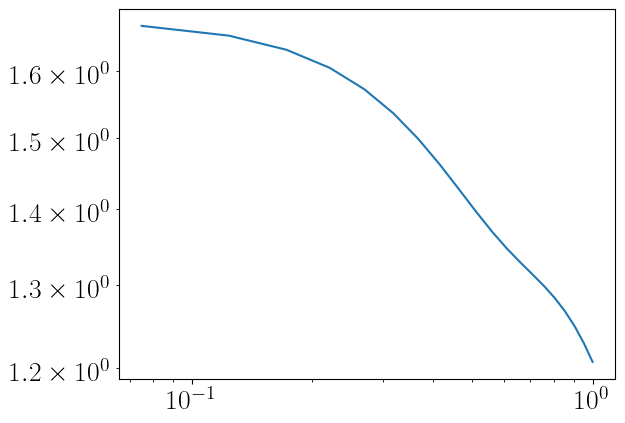

In [234]:
plt.plot(dphi_list, sqrt(array(mse_list))/dphi_list)
# plt.plot(dphi_list, CRB_list)
# plt.plot(dphi_list, array([exp((n_copies*dphi)**2)/n_copies**2 - dphi**2 for dphi in dphi_list]))
plt.xscale("log")
plt.yscale("log")